In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
import json
import time
from shapely.geometry import box,LineString,Point,MultiPoint,MultiLineString,MultiPolygon,Polygon
from shapely.ops import unary_union
import socket
from collections import defaultdict
from numba import prange
import gc
current_dir = os.path.join(os.getcwd()) 
mother_path = os.path.abspath(os.path.join(current_dir, os.pardir))
print('mother_path:', mother_path)
sys.path.append(os.path.join(mother_path, 'PreProcessing'))
sys.path.append(os.path.join(mother_path))
from FittingProcedures import *
from plot import *
from Potential import *
from Grid import *
from PreprocessingObj import *
from ODfromfma import *
import time
from GeometrySphere import *
from Polycentrism import *
from PolycentrismPlot import *
from ModifyPotential import *
from MainPolycentrism import *
from GenerateModifiedFluxesSimulation import *

#import rustworkx as rw
import ast
## BASIC PARAMS
gc.set_threshold(10000,50,50)
plt.rcParams.update({
    "text.usetex": False,
})

if socket.gethostname()=='artemis.ist.berkeley.edu':
    TRAFFIC_DIR = '/home/alberto/LPSim/traffic_phase_transition'
else:
    TRAFFIC_DIR = os.getenv('TRAFFIC_DIR')
name = 'BOS'
grid_size = 0.02
hexagon_resolution = 8
dir_grid = os.path.join(TRAFFIC_DIR,'data','carto',name,'grid',str(grid_size))

## BASIC NEEDED OBJECTS
SFO_obj = GeometricalSettingsSpatialPartition(name,TRAFFIC_DIR)
bbox = SFO_obj.bounding_box
minx, miny, maxx, maxy = bbox
dir_geometries = os.path.join(TRAFFIC_DIR,'data','carto','{0}'.format(name))
grid = GetGrid(grid_size,SFO_obj.bounding_box,'EPSG:4326',dir_geometries)
grid = GetBoundariesInterior(grid,SFO_obj)
df_distance,FoundDistMat = GetDirectionMatrix(dir_geometries,grid_size)
Tij = GetODGrid(dir_geometries,str(grid_size))
lattice = nx.read_graphml(os.path.join(dir_grid,"centroid_lattice.graphml"))
#VectorField = pd.read_csv('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/VectorField.csv')
#Potential = pd.read_csv('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/PotentialDataFrame.csv')

# GET POTENTIAL AND VECTOR FIELD
VectorField = GetVectorField(Tij,df_distance)
VectorFieldDir = os.path.join(TRAFFIC_DIR,'data','carto',name,'grid',str(grid_size))
lattice = GetPotentialLattice(lattice,VectorField)
lattice = SmoothPotential(lattice)
PotentialDataframe = ConvertLattice2PotentialDataframe(lattice)
PotentialDataframe = CompletePotentialDataFrame(VectorField,grid,PotentialDataframe)
SumPot = np.sum(PotentialDataframe['V_out']) 
NumGridEdge = grid[grid['relation_to_line']=='edge'].shape[0]




mother_path: /home/alberto/LPSim/traffic_phase_transition/scripts
PyMC3 not installed
Initialize Grid: 0.02
ALREADY COMPUTED
Get Boundaries: 
Boundary Type:  <class 'shapely.geometry.multipolygon.MultiPolygon'>


KeyboardInterrupt: 

# Compute Boundaries

# COMPUTE PI

##### FIND VMAX

In [ ]:
'''
Look for maximal configuration of POT D POT. I do not trust the Pereira approach to the problem.
Input:
    Indices of the grid that are inside the polygon
Description:
    Looking for max starting from an homogeneous configuration of the potential fixed the distances among different parts of the grid
'''
import numpy as np
from scipy.optimize import minimize,anneal
from deap import base, creator, tools, algorithms
from pyswarm import pso

# Objective function
def objective_function(ViVj,Filtered_Distance):
    return np.sum(ViVj * Filtered_Distance)

# Constraint function: sum of rows and columns should be constant
def constraint_function(V,SumPot):
    return np.sum(V, axis=0) - constant_sum_rows

def MinimizationSquares(initial_V,d_ij,SumPot,verbose = True):
    '''
        Trying to minimize the V function for the PI. 
        I do not trust the ansatz Pereira uses to define the most polycentric city.
    '''
    # Bounds for V (optional, but can help guide the optimization)
    bounds = [(0, SumPot)] * len(initial_V)  # V_i should be non-negative
    # Constraints for V (equality constraints for sum of rows and columns)
    constraints = ({'type': 'eq', 'fun': constraint_function})
    # Optimization
    result = minimize(objective_function, initial_V.flatten(), args=(d_ij.flatten()), method='SLSQP', bounds=bounds, constraints=constraints)
    # Reshape the optimized V matrix
    optimal_V = result.x.reshape(3, 3)
    if verbose:
        print("Optimal V:")
        print(optimal_V)
        print("Objective function value:", result.fun)

def MinimizationAnnealing(initial_V,d_ij,verbose = True):
    result = anneal(objective_function, initial_V.flatten(), args=(d_ij.flatten()), constraint=constraint_function)

    # Reshape the optimized V matrix
    optimal_V = result.reshape(3, 3)
    if verbose:
        print("Optimal V:")
        print(optimal_V)
        print("Objective function value:", objective_function(optimal_V.flatten(), d_ij.flatten()))    


def MinimizationByGeneticAlgo(verbose = True):
    creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
    creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, 0, 10)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=9)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", objective_function, d=d_ij.flatten())
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Optimization
    population = toolbox.population(n=50)
    algorithms.eaMuPlusLambda(population, toolbox, mu=50, lambda_=100, cxpb=0.5, mutpb=0.2, ngen=100)

    # Get the best individual
    best_individual = tools.selBest(population, k=1)[0]

    # Reshape the optimized V matrix
    optimal_V = np.array(best_individual).reshape(3, 3)
    if verbose:
        print("Optimal V:")
        print(optimal_V)
        print("Objective function value:", objective_function(best_individual, d_ij.flatten())[0])    
# Tira dadi per Arrotondare a intero i flussi

##### COMPUTE POLYCENTRISM

# GENERATE NEW CONFIGURATIONS

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Modify Morphology 2
Center Settings: 
Type:  exponential
Covariance: (1,1
******************
Number of grids with people:  2157
Number of couples of grids with flux:  131478
Total Population:  4546481.94410453
Total Flux:  681885
Fraction of grids populated:  0.6203623813632442
Fraction of couples of grids with fluxes:  0.010875361645602571
******************
Plotting fluxes coming from raw data


PIPELINE MODIFICATION FLUXES starting...
++++++++++++ Generate Index Centers ++++++++++++
Number of Populated Grids:  1857
Average distance from Center:  28.965270752306463
+++++++++ Setting Covariances ++++++++
Isotropic and Not Random
Multiplicator:  0.023732278969104757
Number of people in grid with flux >  1 :  22052
Number of couples of grids with flux >  1 :  22052
Fraction of couples of grids with flux >  1 :  0.0018240578272321444
Number of people in grid with flux >  5 :  13754
Number of couples of grids with flux >  5 :  13754
Fraction of couples of grids with flux >  5 :  0.0011376787300812132
Number of people in grid with flux >  10 :  9590
Number of couples of grids with flux >  10 :  9590
Fraction of couples of grids with flux >  10 :  0.0007932484383800229
Number of people in grid with flux >  20 :  6902
Number of couples of grids with flux >  20 :  6902
Fraction of couples of grids with flux >  20 :  0.0005709072702501478
Number of people in grid with flux >  30 :  4960

OSError: Cannot save file into a non-existent directory: '/home/alberto/LPSim/LivingCity/berkeley_2018/new_full_network/OD'

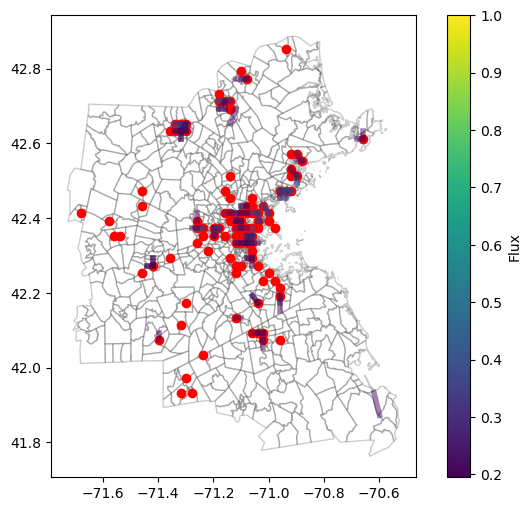

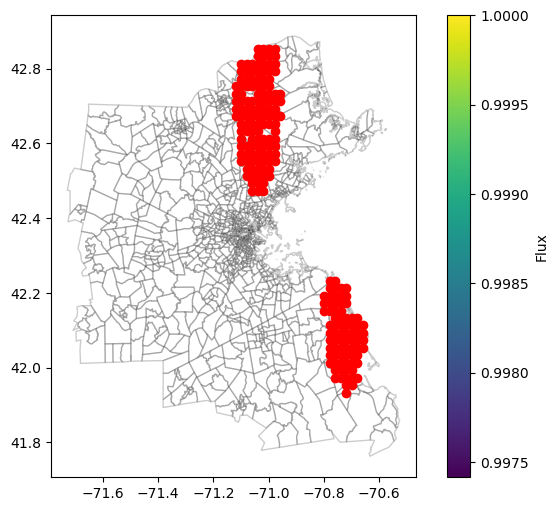

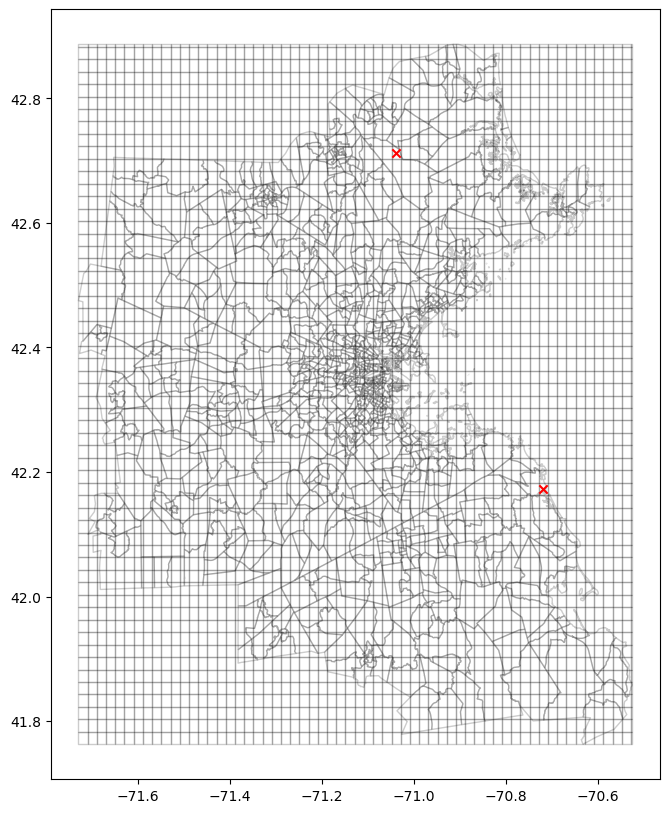

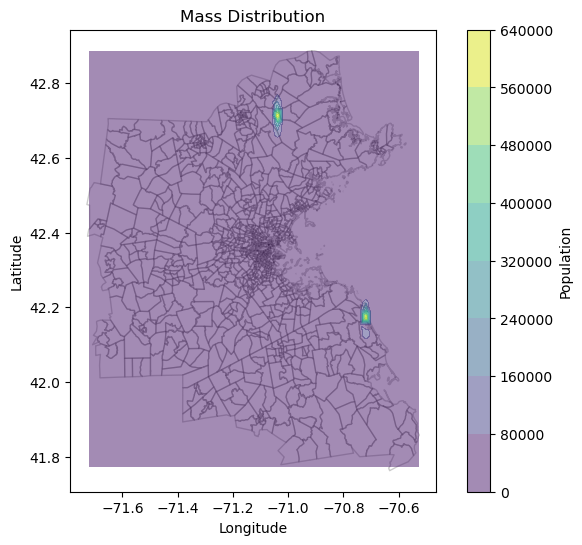

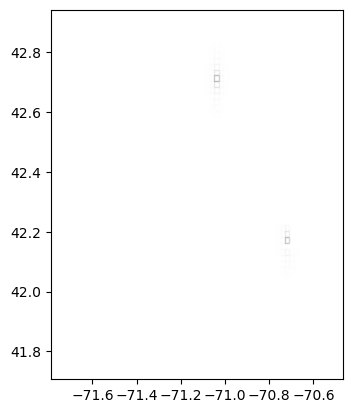

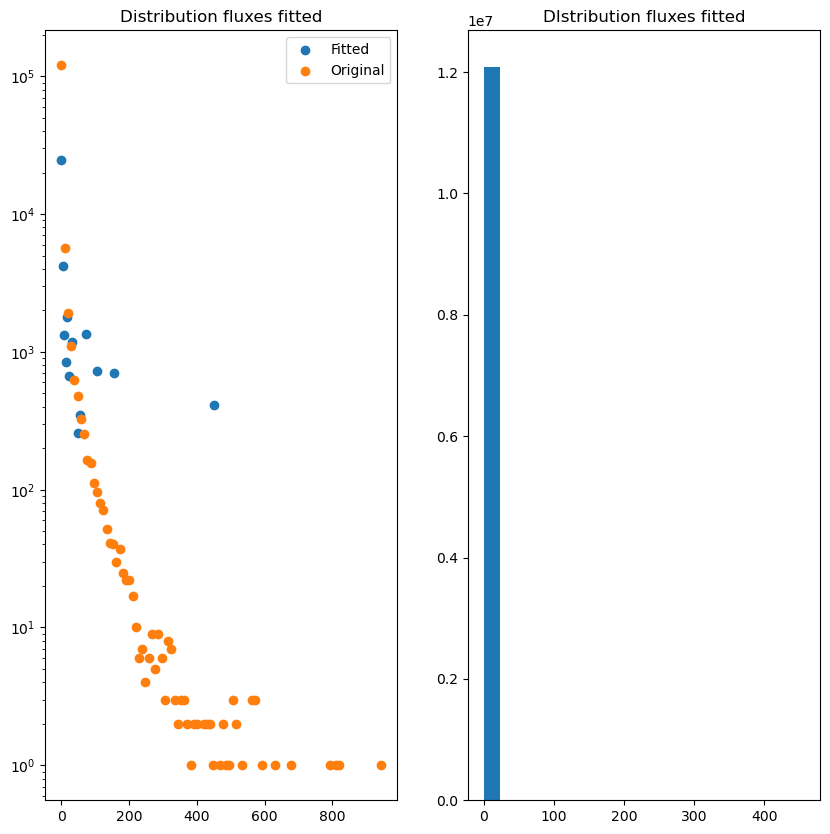

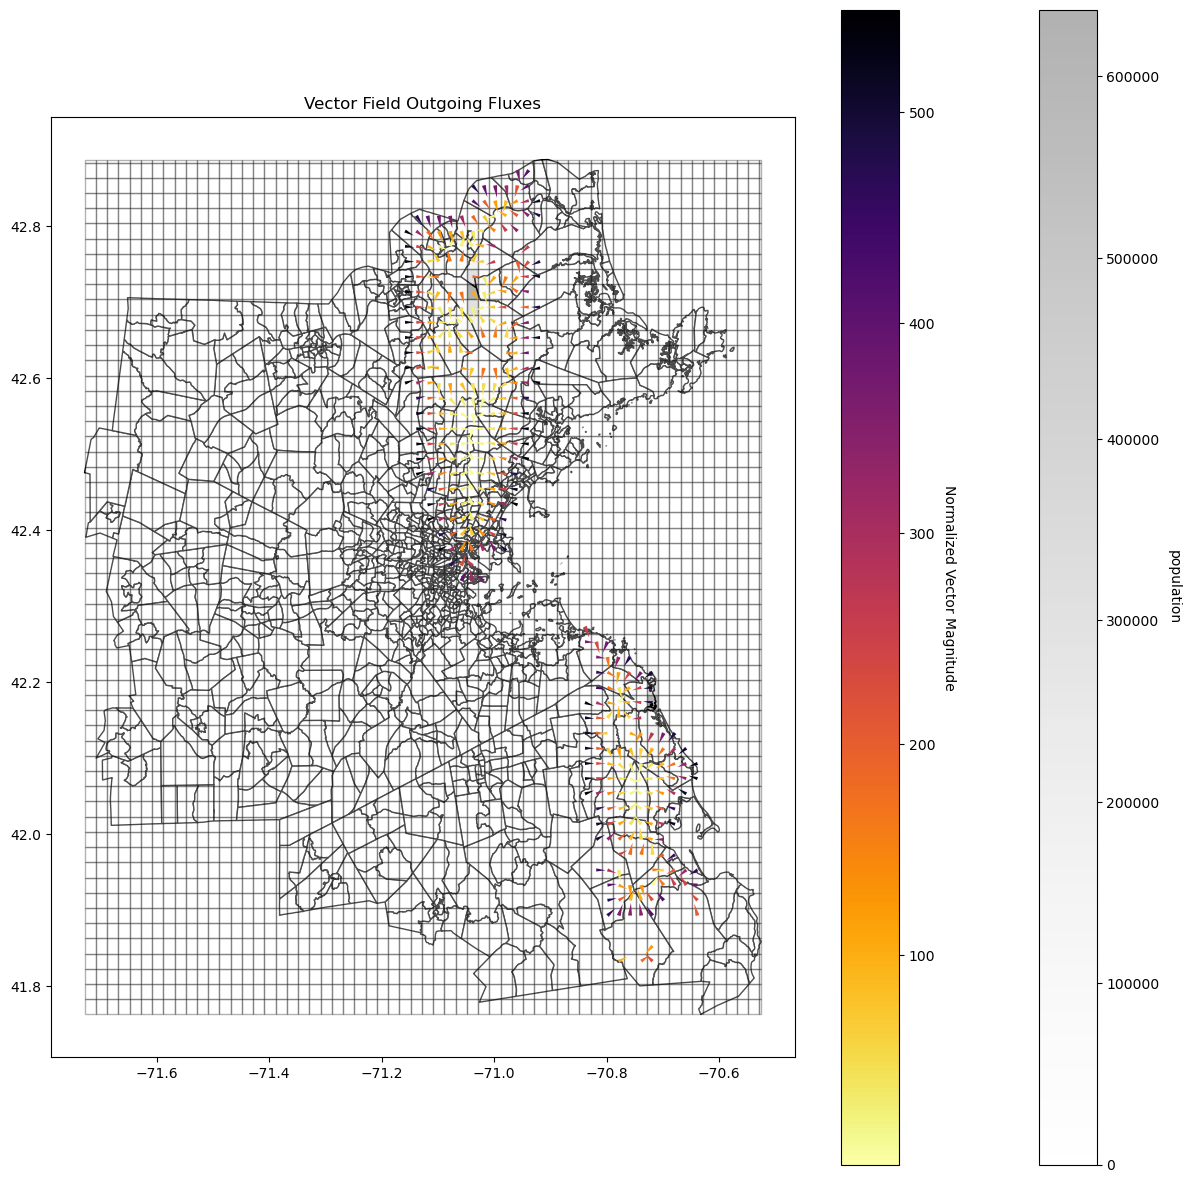

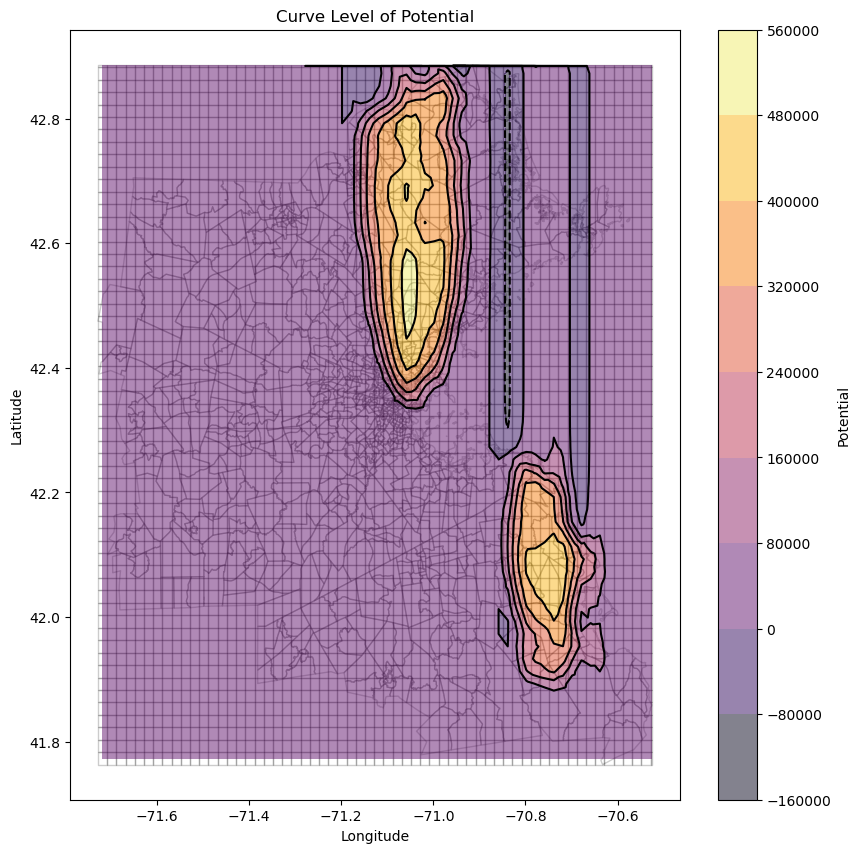

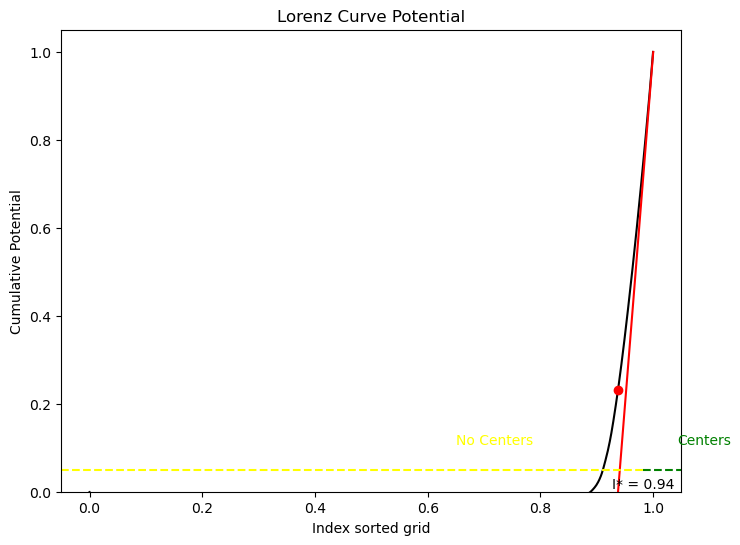

In [ ]:
import os
TRAFFIC_DIR = '/home/alberto/LPSim/traffic_phase_transition'
with open(os.path.join(TRAFFIC_DIR,'data','carto',name,'grid','0.02','origindest2grid.json'),'r') as f:
    OD2grid = json.load(f)

with open(os.path.join(TRAFFIC_DIR,'data','carto',name,'grid','0.02','grid2origindest.json'),'r') as f:
    grid2OD = json.load(f)
with open(os.path.join(TRAFFIC_DIR,'data','carto',name,'osmid2idx.json'),'r') as f:
    osmid2index = json.load(f)

list_peaks = [2,3,4,5,6,8,10,100,200,500] # [2,3,4,5,6,8,10,
InfoConfigurationPolicentricity = {num_peaks: defaultdict() for num_peaks in list_peaks}
Covarinaces = [1,2,4,8,10,15,20,30,50,100]
for cv in Covarinaces:
    for distribution in ['exponential']:#['gaussian','exponential']:#,'exponential']: # NOTE: There is some problem with the exponential distribution
        InfoCenters = {'center_settings': {"type":distribution},'covariance_settings':{"covariances":{"cvx":cv,"cvy":cv},"Isotropic": True,"Random": False}}
        #parameter_values = ((InfoConfigurationPolicentricity,grid,SFO_obj,Tij,df_distance,num_peaks) for num_peaks in list_peaks)
        for num_peaks in list_peaks:
            InfoConfigurationPolicentricity,UCI = ModifyMorphologyCity(InfoConfigurationPolicentricity,grid,SFO_obj,Tij,df_distance,lattice,num_peaks,TRAFFIC_DIR,name,grid_size,InfoCenters,fraction_fluxes = 200,verbose = True)
            if socket.gethostname()=='artemis.ist.berkeley.edu':
                SaveOd = "/home/alberto/LPSim/LivingCity/berkeley_2018/new_full_network"
            else:
                SaveOd = f'/home/aamad/Desktop/phd/traffic_phase_transition/data/carto/{name}/OD'
            OD_from_T_Modified(InfoConfigurationPolicentricity[num_peaks]['Tij'],CityName2RminRmax,name,osmid2index,grid2OD,1,SaveOd,7,8,round(UCI,3))
#with multiprocessing.Pool(processes=multiprocessing.cpu_count() - 4) as pool:
    # Map the function to the parameter values
#    pool.map(ModifyMorphologyCity, parameter_values)


In [4]:
os.getcwd()

'/home/alberto/LPSim/traffic_phase_transition/scripts/GeometrySphere'

# CREATION OD FILES

In [ ]:
'''
{'logk': 0.0003055803472447064, 'alpha': 0.0002546775749831938, 'gamma': -0.07627729954795813, '1/d0': 4.8774299414384545}
Number centers considered:  2
[ 3.37484752 51.76501691]
bin index:  2
Length filtered grid:  32  rv:  3.3748475174250743
bin index:  23
Length filtered grid:  60  rv:  51.76501690675754
New population:  574776957.9199114
k:  1.0003056270416752  alpha:  0.0002546775749831938  beta:  -0.07627729954795813  d0:  4.8774299414384545
<k*p>:  165358.83
<p**alpha>:  1.0017573
<p**beta>:  0.6491281
<exp(-d/d0)>:  0.010571069

'''


with open('/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/BOS/potential/FitVespignani.json','r')as f:
    fitGLM = json.load(f)
print(fitGLM)
k = np.exp(fitGLM['logk'])
alpha =fitGLM['alpha']
beta = fitGLM['gamma']
d0 = fitGLM['1/d0']
list_peaks = [2,3,4,5,6,8,10]
InfoConfigurationPolicentricity = {num_peaks: defaultdict() for num_peaks in list_peaks}
total_population = np.sum(grid['population'])
total_flux = np.sum(Tij['number_people'])

population,centroidx,centroidy,index,filtered_grid = FilterPopulation(grid)
coords_center,_ = ExtractCenterByPopulation(grid)

#CenterMass = ComputeCM(grid,coords_center)

grid['is_populated'] = grid['population']>0
grid['coords'] = grid.apply(lambda x: ProjCoordsTangentSpace(x['centroidx'],x['centroidy'],coords_center[0],coords_center[1]),axis = 1)
grid['distance_from_center'] = grid.apply(lambda x: polar_coordinates(np.array([x['centroidx'],x['centroidy']]),np.array(x['coords']))[0],axis = 1)
PrintInfoFluxPop(grid,Tij)
for num_peaks in list_peaks:
    InfoConfigurationPolicentricity[num_peaks]['grid'] = grid.copy()
    InfoConfigurationPolicentricity[num_peaks]['Tij'] = Tij.copy()
for num_peaks in list_peaks:
    print('Number centers considered: ',num_peaks)
    index_centers = GenerateIndexCenters(grid,num_peaks)
    PlotPositionCenters(grid,SFO_obj,index_centers)
    covariances = SetCovariances(index_centers)
    new_population = ComputeNewPopulation(grid,index_centers,covariances,total_population)
    # Store Data About Population and Fluxes
    
    Factor = np.sum(grid['population'])/np.sum(new_population)
    new_population = new_population*Factor
    InfoConfigurationPolicentricity[num_peaks]['grid']['population'] = new_population
    InfoConfigurationPolicentricity[num_peaks]['grid'].plot(column = 'population')
    plt.show()
#    IPF = ipfn.ipfn(np.array([new_population]), np.array([[int(total_population)]]), np.array([[0]]),convergence_rate=0.01, max_iteration=1000, verbose=True)
#    new_population_ipfn = IPF.iteration()
#    InfoConfigurationPolicentricity[num_peaks]['grid']['new_population'] = new_population_ipfn[0][0]
    t0 = time.time() 
    Modified_Fluxes =  GravitationalModel(InfoConfigurationPolicentricity[num_peaks]['grid']['population'].to_numpy(dtype = np.float32),df_distance['distance'].to_numpy(dtype = np.float32),k,alpha,beta,d0)
    Multiplicator = total_flux/Modified_Fluxes.sum()
    Modified_Fluxes = Modified_Fluxes*Multiplicator
    t1 = time.time()
    print('Time to compute the model: ',t1 - t0)
    t0 = time.time()
#    IPF = ipfn.ipfn(np.array([Modified_Fluxes]), np.array([[total_flux]]), np.array([[0]]),convergence_rate=0.01, max_iteration=1000, verbose=True)
#    Modified_Fluxes_ipfn = IPF.iteration()
    InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people'] = Modified_Fluxes    #Modified_Fluxes_ipfn[0][0]    
    print('Afeter Population Generation and Gravity:')
    PrintInfoFluxPop(InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['Tij'])
    print("----------------------------------")
    n,bins = np.histogram(InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people'].loc[InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people']>0],bins = 100)
    n1,bins1 = np.histogram(Tij['number_people'].loc[Tij['number_people']>0],bins = 100)
    plt.scatter(bins[:-1],n)
    plt.scatter(bins1[:-1],n1)
    plt.yscale('log')
    plt.legend(['Fitted','Original'])
    plt.title('DIstribution fluxes fitted')
    plt.show()
    plt.hist(InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people'],bins = 20)
    plt.title('DIstribution fluxes fitted')
    plt.show()
    t1 = time.time()
    print('Time to compute the ipfn: ',t1 - t0)    
    t0 = time.time()
    InfoConfigurationPolicentricity[num_peaks]['vector_field'] = GetVectorField(InfoConfigurationPolicentricity[num_peaks]['Tij'],df_distance)
    t1 = time.time()
    print('Time to compute the vector field: ',t1 - t0)
    lattice = GetPotentialLattice(lattice,InfoConfigurationPolicentricity[num_peaks]['vector_field'])
    lattice = SmoothPotential(lattice)
    InfoConfigurationPolicentricity[num_peaks]['potential'] = ConvertLattice2PotentialDataframe(lattice)
    InfoConfigurationPolicentricity[num_peaks]['potential'] = CompletePotentialDataFrame(VectorField,InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['potential'])
    print('*********** COMPUTE UCI ************')
    SumPot = InfoConfigurationPolicentricity[num_peaks]['potential']['V_out'].sum()
    NumGridEdge = grid[grid['relation_to_line']=='edge'].shape[0]
    PI = LaunchComputationPI(df_distance,InfoConfigurationPolicentricity[num_peaks]['grid'],SumPot,NumGridEdge,InfoConfigurationPolicentricity[num_peaks]['potential'])
    result_indices,angle,cumulative,Fstar = LorenzCenters(InfoConfigurationPolicentricity[num_peaks]['potential']['V_out'].to_numpy())
    InfoConfigurationPolicentricity[num_peaks]['PI'] = PI
    LC = Fstar/len(cumulative)
    InfoConfigurationPolicentricity[num_peaks]['LC'] = LC
    UCI = PI*LC
    InfoConfigurationPolicentricity[num_peaks]['UCI'] = UCI
    print('Sum Potential: ',SumPot)
    print('Number of Edges boundary: ',NumGridEdge)
    print('LC: ',LC,'PI: ',PI,'UCI: ',UCI)
    print('************PLOTTING************')
    dir_grid = os.path.join(TRAFFIC_DIR,'data','carto',name,'OD')
    if not os.path.exists(dir_grid):
        os.mkdir(dir_grid)
    dir_grid = os.path.join(dir_grid,str(grid_size))
    if not os.path.exists(dir_grid):
        os.mkdir(dir_grid)
    dir_grid = os.path.join(dir_grid,str(num_peaks))
    if not os.path.exists(dir_grid):
        os.mkdir(dir_grid)
    dir_grid = os.path.join(dir_grid,'UCI_{}'.format(round(UCI,3)))
    if not os.path.exists(dir_grid):
        os.mkdir(dir_grid)
    PlotVFPotMass(InfoConfigurationPolicentricity[num_peaks]['grid'],SFO_obj,InfoConfigurationPolicentricity[num_peaks]['potential'],InfoConfigurationPolicentricity[num_peaks]['vector_field'],dir_grid,label_potential = 'population',label_fluxes = 'Ti')
    PotentialContour(InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['potential'],SFO_obj,dir_grid)
    PotentialSurface(InfoConfigurationPolicentricity[num_peaks]['grid'],SFO_obj,InfoConfigurationPolicentricity[num_peaks]['potential'],dir_grid)
    PlotRotorDistribution(InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['potential'],dir_grid)
    fig,ax = plt.subplots(1,1,figsize = (10,10))
    PlotLorenzCurve(ax,cumulative,Fstar,result_indices,shift = 0.1)

    

In [ ]:
PlotVFPotMass(InfoConfigurationPolicentricity[num_peaks]['grid'],SFO_obj,InfoConfigurationPolicentricity[num_peaks]['potential'],InfoConfigurationPolicentricity[num_peaks]['vector_field'],dir_grid,label_potential = 'population',label_fluxes = 'Ti')
PotentialContour(InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['potential'],SFO_obj,dir_grid)
PotentialSurface(InfoConfigurationPolicentricity[num_peaks]['grid'],SFO_obj,InfoConfigurationPolicentricity[num_peaks]['potential'],dir_grid)
PlotRotorDistribution(InfoConfigurationPolicentricity[num_peaks]['grid'],InfoConfigurationPolicentricity[num_peaks]['potential'],dir_grid)
fig,ax = plt.subplots(1,1,figsize = (10,10))
PlotLorenzCurve(ax,cumulative,Fstar,result_indices,shift = 0.1)
